In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import sampler
import time

In [2]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channals, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channals, **kwargs)
        self.bn = nn.BatchNorm2d(out_channals)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x)


# Inception
class Inception(nn.Module):
    def __init__(self, input_size,
                 n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = BasicConv2d(input_size, n1x1, kernel_size=1)

        # 1x1 conv -> 3x3 conv branch
        self.b2_1x1_a = BasicConv2d(input_size, n3x3red,
                                    kernel_size=1)
        self.b2_3x3_b = BasicConv2d(n3x3red, n3x3,
                                    kernel_size=3, padding=1)

        # 1x1 conv -> 3x3 conv -> 3x3 conv branch
        self.b3_1x1_a = BasicConv2d(input_size, n5x5red,
                                    kernel_size=1)
        self.b3_3x3_b = BasicConv2d(n5x5red, n5x5,
                                    kernel_size=3, padding=1)
        self.b3_3x3_c = BasicConv2d(n5x5, n5x5,
                                    kernel_size=3, padding=1)

        # 3x3 pool -> 1x1 conv branch
        self.b4_pool = nn.MaxPool2d(3, stride=1, padding=1)
        self.b4_1x1 = BasicConv2d(input_size, pool_planes,
                                  kernel_size=1)

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2_3x3_b(self.b2_1x1_a(x))
        y3 = self.b3_3x3_c(self.b3_3x3_b(self.b3_1x1_a(x)))
        y4 = self.b4_1x1(self.b4_pool(x))
        # y的维度为[batch_size, out_channels, C_out,L_out]
        # 合并不同卷积下的特征图
        return torch.cat([y1, y2, y3, y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = BasicConv2d(3, 192, kernel_size=3, padding=1)

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(2, stride=2)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


class GoogleNet2(nn.Module):
    def __init__(self):
        super(GoogleNet2, self).__init__()
        self.pre_layers = BasicConv2d(3, 16, kernel_size=3, padding=1)
        self.a1 = Inception(16, 16, 32, 32, 16, 32, 16)
        self.a2 = Inception(96, 64, 64, 32, 16, 16, 16)

        self.a4 = Inception(128, 64, 64, 32, 16, 16, 16)
        self.a5 = Inception(128, 256, 64, 64, 64, 128, 64)

        self.a7 = Inception(512, 512, 128, 256, 64, 128, 128)

        self.maxpool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a2(self.a1(out))
        out = self.maxpool(out)
        out = self.a5(self.a4(out))
        out = self.maxpool(out)
        out = self.avgpool(self.a7(out))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
#  dataloader!
NUM = 49000
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM)))
cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM, 50000)))
cifar10_test = dset.CIFAR10('./datasets', train=False, download=True,
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


In [4]:
param = {}
param['lr'] = 1e-5
param['epochs'] = 30

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = GoogleNet2().to(device).train()
# print(model)
criterion = nn.CrossEntropyLoss()
optim = optim.Adam(model.parameters(), lr=param['lr'])
total_step = len(loader_train)

losses = []
accs = []

cuda


In [6]:
time_start = time.time()

# train
for epoch in range(param['epochs']):
    for i, (image, label) in enumerate(loader_train):
        image = image.to(device, dtype=torch.float32)
        label = label.to(device, dtype=torch.long)

        scores = model(image)
        loss = criterion(scores, label)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, param['epochs'], i + 1, total_step, loss.item()))
            losses.append(loss.item())

    with torch.no_grad():
        correct, total = 0, 0
        model = model.eval()
        # test!
        for image, label in loader_val:
            image = image.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.long)
            output = model(image)
            _, pred = torch.max(output.data, 1)
            total += label.size(0)
            correct += (label == pred).sum().item()

        accuracy = correct/total
        accs.append(accuracy)
        print('Accuracy of the network on the test images: {:.2f} %'.format(100*accuracy))
    model = model.train()
time_end = time.time()

Epoch [1/30], Step [100/766], Loss: 2.1021
Epoch [1/30], Step [200/766], Loss: 1.9446
Epoch [1/30], Step [300/766], Loss: 1.7216
Epoch [1/30], Step [400/766], Loss: 1.8967
Epoch [1/30], Step [500/766], Loss: 1.6298
Epoch [1/30], Step [600/766], Loss: 1.6199
Epoch [1/30], Step [700/766], Loss: 1.7476
Accuracy of the network on the test images: 42.40 %
Epoch [2/30], Step [100/766], Loss: 1.5047
Epoch [2/30], Step [200/766], Loss: 1.5030
Epoch [2/30], Step [300/766], Loss: 1.5119
Epoch [2/30], Step [400/766], Loss: 1.4611
Epoch [2/30], Step [500/766], Loss: 1.4521
Epoch [2/30], Step [600/766], Loss: 1.4043
Epoch [2/30], Step [700/766], Loss: 1.2106
Accuracy of the network on the test images: 49.00 %
Epoch [3/30], Step [100/766], Loss: 1.2327
Epoch [3/30], Step [200/766], Loss: 1.3835
Epoch [3/30], Step [300/766], Loss: 1.2541
Epoch [3/30], Step [400/766], Loss: 1.4160
Epoch [3/30], Step [500/766], Loss: 1.4191
Epoch [3/30], Step [600/766], Loss: 1.3516
Epoch [3/30], Step [700/766], Loss: 

Time: 1526.59


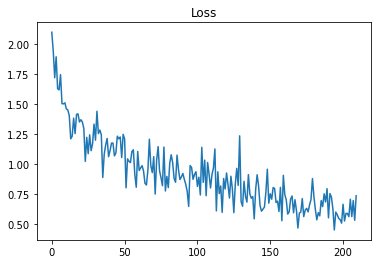

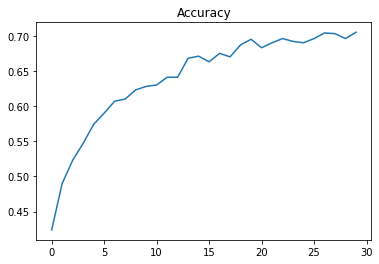

In [7]:
print('Time: {:.2f}'.format(time_end-time_start))
plt.figure()
plt.title('Loss')
plt.plot(losses)
plt.figure()
plt.title('Accuracy')
plt.plot(accs)
plt.show()

In [8]:
with torch.no_grad():
        correct, total = 0, 0
        model = model.eval()
        # test!
        for image, label in loader_test:
            image = image.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.long)
            output = model(image)
            _, pred = torch.max(output.data, 1)
            total += label.size(0)
            correct += (label == pred).sum().item()

        accuracy = correct/total
        accs.append(accuracy)
        print('Accuracy of the network on the test images: {:.2f} %'.format(100*accuracy))

Accuracy of the network on the test images: 71.37 %
